In [17]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import random
import sys

import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, utils, models
sys.path.append("/content/gdrive/My Drive/Hex/")
from hex import player, game, board
import util
import move_evaluator
import move_generator

In [ ]:
games = pd.read_csv("/content/gdrive/My Drive/Hex/joineddata.csv")

In [ ]:
model = tf.keras.Sequential([
    layers.Conv2D(128, kernel_size=(3, 3),
                  activation='relu',
                  input_shape=(17, 17, 2),
                  padding="same"
                 ),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.5),
    layers.Conv2D(128, (3, 3), activation ="relu", padding="same"),
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')])

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy']
             )

In [ ]:
games_over_2 = games[games["move_list"].str.len() > 4]
for i in range 
    games_over_2[i * 15000: (i + 1) * 15000]

    boards, winners = util.makeInputOutputTotal(games_over_2["move_list"].values,
                                            games_over_2["winner"].values ,scraped=scraped)
    boards = np.swapaxes(np.swapaxes(boards, 1, 2), 2, 3)
    model.fit(boards.reshape(list(boards.shape)), winners, epochs=1, validation_split=0.10)


Train on 366555 samples, validate on 40729 samples
Epoch 1/1
366555/366555 [==============================] - 150s 410us/step - loss: 0.5438 - acc: 0.7187 - val_loss: 0.6037 - val_acc: 0.6817


In [ ]:
model.save("/content/gdrive/My Drive/Hex/best_so_far_dropout.h5")

In [ ]:
model = models.load_model("/content/gdrive/My Drive/Hex/best_so_far_dropout.h5")


In [ ]:
def evaluate_win_rate(p, n):
    p2 = player.RandomPlayer()
    new_moves1, new_winners1 = util.generate_games(n // 2, p, p2)
    new_moves2, new_winners2 = util.generate_games(n // 2 + (n % 2), p2, p)
    new_winners1 = pd.Series(new_winners1)
    new_winners2 = pd.Series(new_winners2)
    num_wins = len(new_winners1[new_winners1 == "black"])
    num_wins += len(new_winners2[new_winners2 == "white"])
    print(num_wins)
    return num_wins / n

def simulate_and_save(n, k, p1, p2, model1, model2,  reset=False, filename="generated_games.csv", every=3, save=True, num_games=10):
    p3 = player.RandomPlayer()
    winrates = []
    winrates.append(evaluate_win_rate(p1, num_games))
    for i in range(int(n / k)):
        new_moves1, new_winners1 = util.generate_games((k // 2) + (k % 2), p1, p2)
        new_moves2, new_winners2 = util.generate_games(k // 2, p2, p1)
        new_moves = new_moves1 + new_moves2
        new_winners = new_winners1 + new_winners2
        boards, winners = util.makeInputOutputTotal(new_moves, new_winners, scraped=False)
        model1.fit(np.swapaxes(np.swapaxes(boards, 1, 2), 2, 3), winners, epochs=1, verbose=0)
        if model2 is not None:
            model2.fit(np.swapaxes(np.swapaxes(boards, 1, 2), 2, 3), winners, epochs=1, verbose=0)
        if save:
            model1.save("/content/gdrive/My Drive/Hex/retrained_model1_w.h5")
            if model2 is not None:
                model2.save("/content/gdrive/My Drive/Hex/retrained_model2_w.h5")
            if not reset:
              df = pd.read_csv("/content/gdrive/My Drive/Hex/" + filename)
              joined = pd.concat([df, pd.DataFrame({"moves" : new_moves, "winners" : new_winners}, columns=["moves", "winners"])])
              joined.to_csv("/content/gdrive/My Drive/Hex/" + filename, index=False)
            else:
              pd.DataFrame({"moves" : new_moves, "winners" : new_winners},
                           columns=["moves", "winners"]).to_csv("/content/gdrive/My Drive/Hex/" + filename, index=False)
              reset = False
        if i % every == 0:
            winrates.append(evaluate_win_rate(p1, num_games))
        print(i * k, "to", (i + 1 ) * k)
      
    return model1, model2, winrates


In [ ]:
hanson_model = models.load_model("/content/gdrive/My Drive/Hex/hanson_model.h5")
model = models.load_model("/content/gdrive/My Drive/Hex/best_so_far_dropout.h5")
p1 = player.ModelPlayer(move_generator.ExhaustiveGenerator(), move_evaluator.SimpleMoveEvaluator(model))
p2 = player.ModelPlayer(move_generator.ExhaustiveGenerator(), move_evaluator.SimpleMoveEvaluator(model))
p3 = player.ModelPlayer(move_generator.ExhaustiveGenerator(), move_evaluator.SimpleMoveEvaluator(hanson_model))



In [ ]:
_, _1, winrates = simulate_and_save(30, 2, p1, p2, model, None, every=1, save=False, num_games=50)
with open("/content/gdrive/My Drive/Hex/winrates_same_model.pkl", "wb") as outfile:
  pickle.dump(winrates, outfile)

In [ ]:
_, _1, winrates = simulate_and_save(30, 2, p1, p3, model, hanson_model, every=1, save=False, num_games=50)
with open("/content/gdrive/My Drive/Hex/winrates_different_model.pkl", "wb") as outfile:
  pickle.dump(winrates, outfile)

In [ ]:
_, _1, winrates = simulate_and_save(3000, 10, p1, p3, model, hanson_model, every=3, save=True)
with open("/content/gdrive/My Drive/Hex/final_winrates.pkl", "wb") as outfile:
  pickle.dump(winrates, outfile)

In [72]:
with open("/content/gdrive/My Drive/Hex/winrates_different_model.txt", 'r') as infile:
    winrates = [0.98] + [int(l) / 50 for l in infile][:-2]
print(len(winrates))
with open("/content/gdrive/My Drive/Hex/winrates_different_model.pkl", "wb") as outfile:
   pickle.dump(winrates, outfile)

16


Text(0.5,1,'Same Model: Win Rate by Number of Games Retrained On')

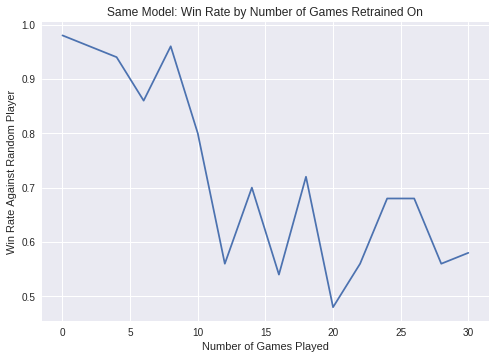

In [62]:
import matplotlib.pyplot as plt
winrates = pickle.load(open("/content/gdrive/My Drive/Hex/winrates_same_model.pkl", "rb"))
games = 2 * np.arange(16)
plt.plot(games, winrates)
plt.xlabel("Number of Games Played")
plt.ylabel("Win Rate over 50 Games Against Random Player")
plt.title("Same Model: Win Rate by Number of Games Retrained On")


Text(0.5,1,'Different Model: Win Rate by Number of Games Retrained On')

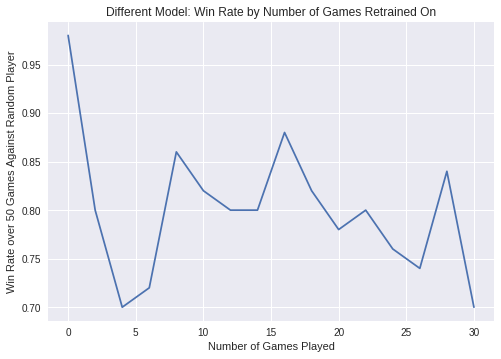

In [75]:
winrates = pickle.load(open("/content/gdrive/My Drive/Hex/winrates_different_model.pkl", "rb"))
games = 2 * np.arange(16)
plt.plot(games, winrates)
plt.xlabel("Number of Games Played")
plt.ylabel("Win Rate over 50 Games Against Random Player")
plt.title("Different Model: Win Rate by Number of Games Retrained On")


Text(0.5,1,'Win Rate by Number of Games Played')

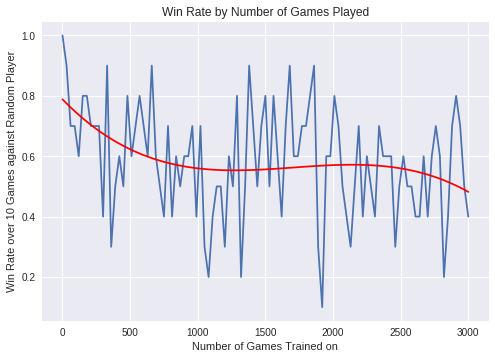

In [78]:
winrates = pickle.load(open("/content/gdrive/My Drive/Hex/final_winrates.pkl", "rb"))

games = 30 * np.arange(101)

# plot the data itself
plt.plot(games, winrates, "-")

# calc the trendline
z = np.polyfit(games, winrates, 3)
p = np.poly1d(z)

plt.plot(games, p(games),"r")
plt.xlabel("Number of Games Trained on")
plt.ylabel("Win Rate over 10 Games against Random Player")
plt.title("Win Rate by Number of Games Played")
